In [1]:
from vlm_finetune import AutoVlmModel, ImageProcessor
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import json
import evaluate
import pandas as pd

### Проведём сравнения двух моделей, зафайнтюненных на демо-ноутбуках

Загружаем датасет и создаём функция для предикта на сэмпле

In [2]:
with open("data/llava_vet_dataset_test.json", "r") as file:
    test_data = json.loads(file.read())
prompt = "Поставь вероятный диагноз по рентгенограмме."


def predict_on_test_dataset(model_name: str, model_path: str, test_data: list[dict[str, str]], prompt: str) -> list[str]:
    answers = []
    model = AutoVlmModel.from_name(
        model_name=model_name, 
        model_path=model_path,
        image_processor=ImageProcessor(image_size=(336, 336)) # ресайзим картинки, чтобы сэкономить память
    )
    for sample in tqdm(test_data):
        model_answer = model.predict(image=sample["image_path"], prompt=prompt)
        answers.append(model_answer)
    return answers

### Предикты LLava

In [3]:
llava_answers = predict_on_test_dataset(
    model_name="llava",
    model_path="models/llava_tuned",
    test_data=test_data,
    prompt=prompt
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

### Предикты Qwen

In [4]:
qwen_answers = predict_on_test_dataset(
    model_name="qwen",
    model_path="models/qwen_tuned",
    test_data=test_data,
    prompt=prompt
)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

### Сравнение моделей

Используем bertscore

In [5]:
bertscore = evaluate.load("bertscore")
answers = [td["answer"] for td in test_data]
llava_score = bertscore.compute(predictions=llava_answers, references=answers, lang="ru")
qwen_score = bertscore.compute(predictions=qwen_answers, references=answers, lang="ru")

In [6]:
eval_df = pd.DataFrame(
    {
        "answer": answers,
        "llava_answer": llava_answers,
        "qwen_answer": qwen_answers,
        "llava_precision": llava_score["precision"],
        "llava_recall": llava_score["recall"],
        "llava_f1": llava_score["f1"],
        "qwen_precision": qwen_score["precision"],
        "qwen_recall": qwen_score["recall"],
        "qwen_f1": qwen_score["f1"]
    }
)
eval_df.to_csv("data/qwen_llava_eval.csv", index=False, sep=";")
eval_df.describe()

,llava_precision,llava_recall,llava_f1,qwen_precision,qwen_recall,qwen_f1
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.800509,0.780929,0.790244,0.702295,0.670647,0.685833
std,0.088699,0.080624,0.082821,0.027431,0.027667,0.023927
min,0.639253,0.658337,0.648655,0.612049,0.620453,0.622061
25%,0.760354,0.716581,0.737819,0.693838,0.657191,0.671305
50%,0.812623,0.781308,0.801636,0.709534,0.670642,0.684434
75%,0.862586,0.815625,0.833437,0.723632,0.686034,0.702533
max,0.935415,0.959252,0.947183,0.739446,0.720661,0.728291


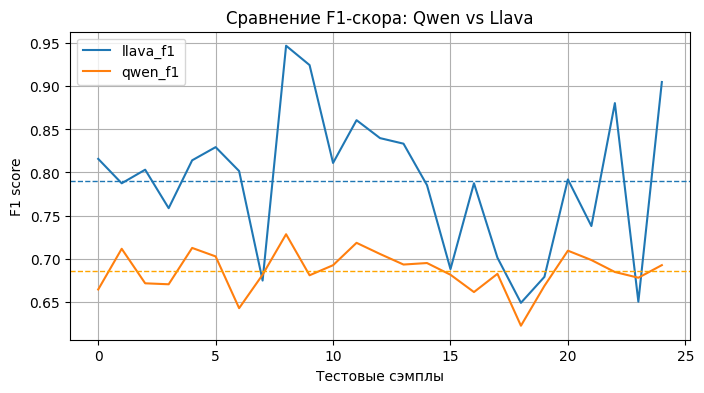

In [7]:
ax = eval_df[["llava_f1", "qwen_f1"]].plot(kind="line", figsize=(8, 4), title="Сравнение F1-скорa: Qwen vs Llava")
ax.set_xlabel("Тестовые сэмплы")
ax.set_ylabel("F1 score")
ax.axhline(eval_df["llava_f1"].mean(), linestyle="--", linewidth=1, label=f"llava_f1 mean ({eval_df['llava_f1'].mean():.2f})")
ax.axhline(eval_df["qwen_f1"].mean(), linestyle="--", color="orange", linewidth=1, label=f"qwen_f1 mean ({eval_df['qwen_f1'].mean():.2f})")
plt.grid(True)
plt.show()

**LLava значительно лучше показала себя на данном датасете, для Qwen стоит поэкспериментировать с гиперпараметрами**